# Precio promedio de la electricidad por horas

El dataset lo obtendremos del portal de datos abiertos de la comunidad de Madrid

In [155]:
import pandas as pd

# Lista para almacenar datos válidos
filas_limpias = []

# Abrimos manualmente línea a línea
with open("final_dataset_clean.csv", encoding="utf-8") as f:
    for linea in f:
        partes = linea.strip().split(",")
        if len(partes) >= 3:
            fecha = partes[0]
            hora = partes[1]
            precio = partes[8].replace(",", ".")  # columna 9 con coma decimal

            try:
                filas_limpias.append([fecha, hora, float(precio)])
            except ValueError:
                continue  # si no se puede convertir a float, salta esa fila

# Crear DataFrame limpio
df = pd.DataFrame(filas_limpias, columns=["date", "hour", "avg_total_price"])

# Convertir fecha a datetime
df["timestamp"] = pd.to_datetime(df["date"] + " " + df["hour"], format="%Y-%m-%d %H:%M", errors="coerce")
df.dropna(subset=["timestamp"], inplace=True)

# Mostrar resultado
print(df.head())
print(f"{len(df)} filas limpias cargadas.")


         date   hour  avg_total_price  timestamp
0  2022-01-12  00:00           26.714 2022-01-12
1  2022-01-12  00:00           26.714 2022-01-12
2  2022-01-12  00:00           26.714 2022-01-12
3  2022-01-12  00:00           26.714 2022-01-12
4  2022-01-12  00:00           26.714 2022-01-12
105102 filas limpias cargadas.


hour_only
00    25.101475
01    23.630434
02    22.613120
03    22.086460
04    21.912101
05    22.248826
06    23.918590
07    26.137405
08    27.638958
09    28.968908
10    29.867077
11    30.262591
12    30.560536
13    30.820630
14    30.436410
15    29.489888
16    28.970147
17    28.853003
18    29.161979
19    29.841467
20    30.565525
21    30.534492
22    28.791984
23    26.526236
Name: avg_total_price, dtype: float64


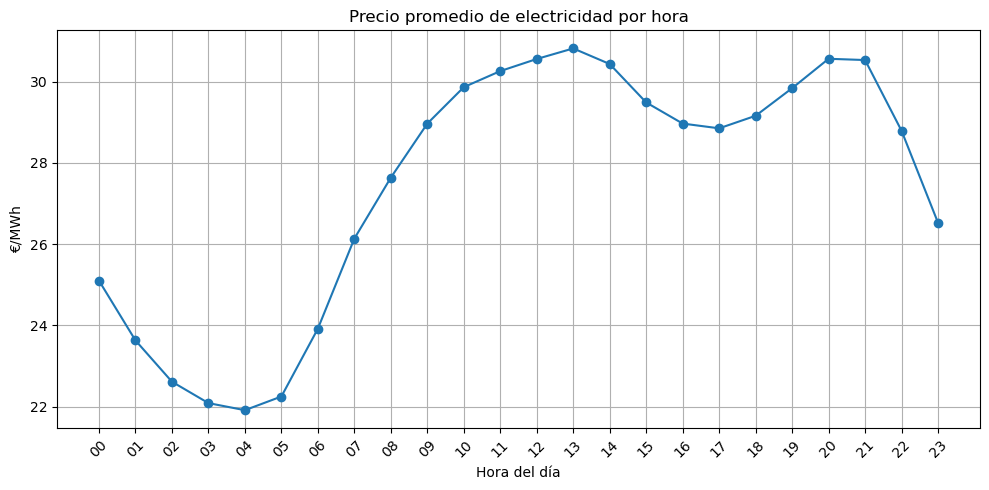

In [156]:
import matplotlib.pyplot as plt

# Asegúrate de que la columna hour sea string con solo la hora (00:00, 01:00, ...)
df["hour_only"] = df["timestamp"].dt.strftime("%H")

# Calculamos el promedio por hora
hourly_avg = df.groupby("hour_only")["avg_total_price"].mean().sort_index()

# Mostramos la tabla
print(hourly_avg)

# Graficamos
plt.figure(figsize=(10, 5))
plt.plot(hourly_avg.index, hourly_avg.values, marker="o")
plt.title("Precio promedio de electricidad por hora")
plt.xlabel("Hora del día")
plt.ylabel("€/MWh")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Podemos observar que las horas con precios valle son entre las 00.00 y las 07.00. Esto se tendrá en cuenta posteriormente para ver las horas de recarga

## Estudio consumo energético de cada estacion

### Desnivel y distancia entre estaciones

Se usaran las apis: Open-Meteo (s.f.), "Open-Meteo", Open-Meteo, [https://open-meteo.com/] y [
 OSRM (2023), "OSRM API Documentation", Project OSRM, [https://project-osrm.org/docs/v5.24.0/api/]

In [157]:
import re
import ast
import pandas as pd
import numpy as np

# Función que opera sobre UN string, no sobre una columna
def parse_coords(s):
    try:
        s = re.sub(r'np\.float64\(([^)]+)\)', r'\1', str(s))  # elimina np.float64(...)
        geo = ast.literal_eval(s)
        return pd.Series(geo['coordinates'], index=['lon', 'lat'])
    except:
        return pd.Series([np.nan, np.nan], index=['lon', 'lat'])

In [158]:
import pandas as pd
import ast

# Cargar el archivo CSV
df_moto = pd.read_csv("motos.csv")

df_moto[['lon_unlock','lat_unlock']] = df_moto['geolocation_unlock'].apply(parse_coords)
df_moto[['lon_lock','lat_lock']]     = df_moto['geolocation_lock'].apply(parse_coords)



In [159]:
import pandas as pd
import requests
import time

# Usamos los nombres de estación y coordenadas únicas
unlock_coords = df_moto[['unlock_station_name', 'lat_unlock', 'lon_unlock']].drop_duplicates()
lock_coords   = df_moto[['lock_station_name', 'lat_lock', 'lon_lock']].drop_duplicates()

# Renombramos para unificarlas
unlock_coords.columns = ['station_name', 'lat', 'lon']
lock_coords.columns   = ['station_name', 'lat', 'lon']

# Combinamos estaciones únicas
stations = pd.concat([unlock_coords, lock_coords]).drop_duplicates(subset=['station_name'])

# Función para obtener altitud usando la API de Open-Meteo
def get_elevation(lat, lon):
    url = f"https://api.open-meteo.com/v1/elevation?latitude={lat}&longitude={lon}"
    try:
        r = requests.get(url, timeout=5)
        r.raise_for_status()
        return r.json()['elevation'][0]
    except:
        return None

# Aplicamos con un pequeño retardo para no saturar la API
altitudes = []
for _, row in stations.iterrows():
    alt = get_elevation(row['lat'], row['lon'])
    altitudes.append(alt)
    time.sleep(0.5)  # pausa para evitar bloqueo

stations['altitude'] = altitudes



In [160]:
# Mostrar las primeras filas del resultado
print(stations.head())

# O bien, guardar en CSV para analizar en Excel o Jupyter
stations.to_csv("altitudes_estaciones.csv", index=False)


                           station_name        lat       lon  altitude
0               52 - Plaza de Santa Ana  40.414423 -3.700716     661.0
1         57 - Santa Cruz del Marcenado  40.429566 -3.712630     672.0
2                186 - General Pardiñas  40.429055 -3.678278     688.0
3                        107 - Columela  40.421525 -3.688437     673.0
4  132 - Glorieta de los Cuatro Caminos  40.446367 -3.703667     706.0


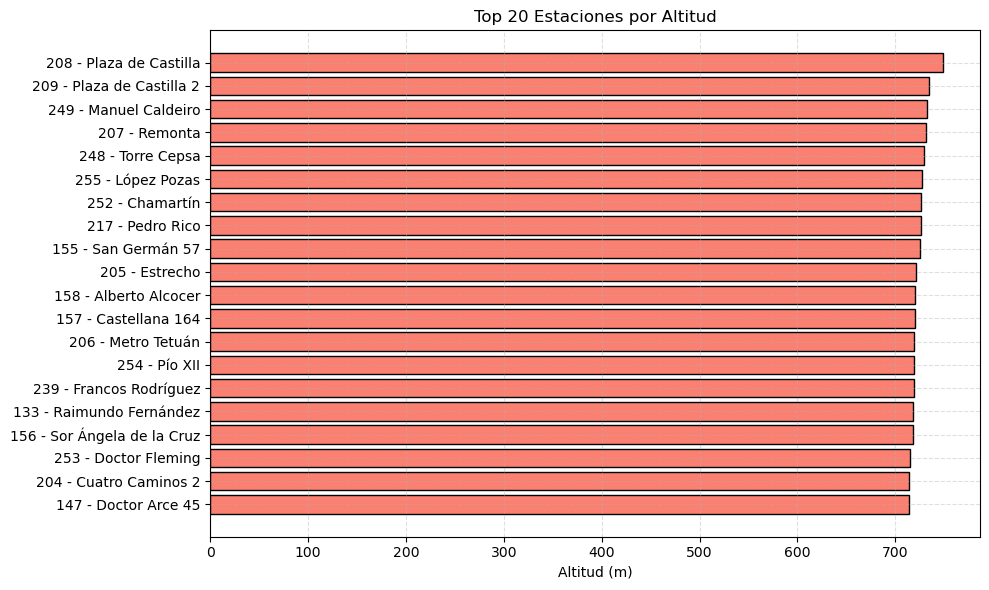

In [161]:
# Top 20 por altitud
top_alt = stations.sort_values(by="altitude", ascending=False).head(20)

plt.figure(figsize=(10, 6))
plt.barh(top_alt["station_name"], top_alt["altitude"], color="salmon", edgecolor="black")
plt.title("Top 20 Estaciones por Altitud")
plt.xlabel("Altitud (m)")
plt.gca().invert_yaxis()  # Para que la más alta quede arriba
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


In [162]:
from math import radians, sin, cos, sqrt, atan2

def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # radio de la Tierra en km
    dlat = radians(lat2 - lat1)
    dlon = radians(lon2 - lon1)

    a = sin(dlat/2)**2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    return R * c  # distancia en km


In [163]:
import pandas as pd
from itertools import combinations

# Dataset con estaciones únicas
stations = df_moto[['unlock_station_name', 'lat_unlock', 'lon_unlock']].drop_duplicates()
stations = stations.rename(columns={
    "unlock_station_name": "station",
    "lat_unlock": "lat",
    "lon_unlock": "lon"
}).reset_index(drop=True)

# Combinar pares únicos
station_pairs = list(combinations(stations.itertuples(index=False), 2))

# Calcular distancias
distances = []
for s1, s2 in station_pairs:
    dist_km = haversine(s1.lat, s1.lon, s2.lat, s2.lon)
    distances.append({
        "origen": s1.station,
        "destino": s2.station,
        "distancia_km": round(dist_km, 3)
    })

df_dist = pd.DataFrame(distances)


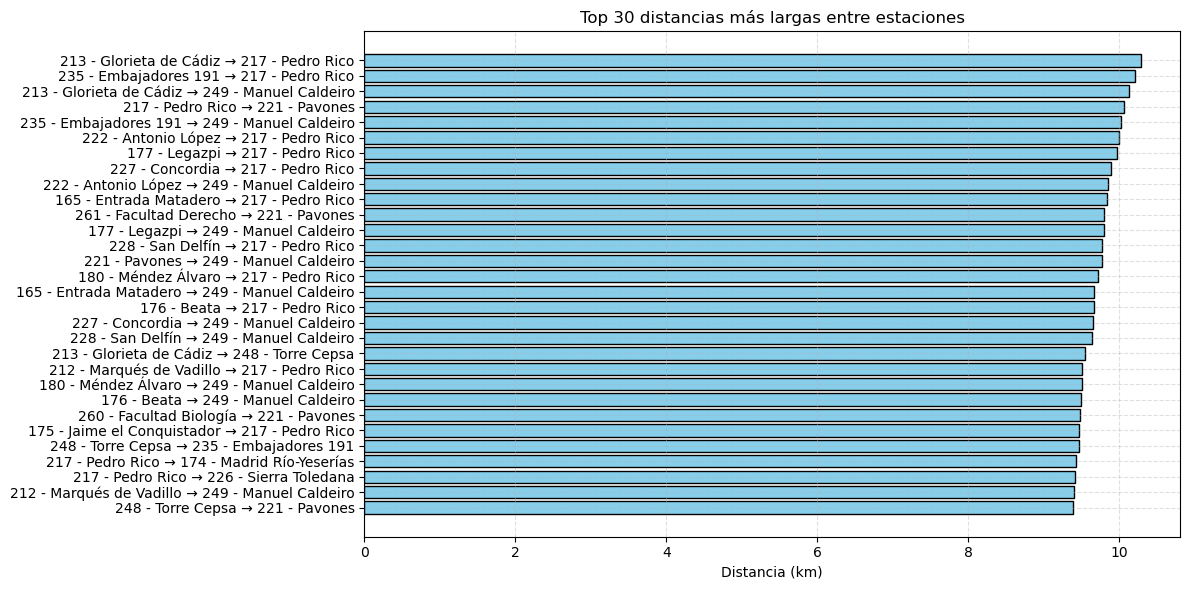

In [164]:
# Mostrar las distancias más grandes
top_dist = df_dist.sort_values(by="distancia_km", ascending=False).head(30)

plt.figure(figsize=(12, 6))
plt.barh(top_dist["origen"] + " → " + top_dist["destino"],
         top_dist["distancia_km"], color="skyblue", edgecolor="black")

plt.title("Top 30 distancias más largas entre estaciones")
plt.xlabel("Distancia (km)")
plt.gca().invert_yaxis()
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()


In [165]:
import pandas as pd
from math import radians, sin, cos, sqrt, atan2
from itertools import product

# Carga tu DataFrame de estaciones, con nombre y altitud
stations = pd.read_csv("altitudes_estaciones.csv")  # debe tener 'station_name', 'lat', 'lon', 'altitude'

# Función haversine para calcular distancia en km
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # radio de la Tierra en km
    dlat = radians(lat2 - lat1)
    dlon = radians(lon2 - lon1)
    a = sin(dlat/2)**2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    return R * c

# Genera todas las combinaciones posibles (excepto origen=destino)
pairs = list(product(stations.itertuples(), repeat=2))
data = []
for s1, s2 in pairs:
    if s1.station_name == s2.station_name:
        continue  # evita calcular de una estación a sí misma
    distancia = haversine(s1.lat, s1.lon, s2.lat, s2.lon)
    desnivel = s2.altitude - s1.altitude
    data.append({
        "Origen": s1.station_name,
        "Destino": s2.station_name,
        "Distancia_km": round(distancia, 4),
        "Desnivel": round(desnivel, 1)
    })

df_result = pd.DataFrame(data)
df_result.head()



,Origen,Destino,Distancia_km,Desnivel
0,52 - Plaza de Santa Ana,57 - Santa Cruz del Marcenado,1.9628,11.0
1,52 - Plaza de Santa Ana,186 - General Pardiñas,2.5011,27.0
2,52 - Plaza de Santa Ana,107 - Columela,1.3055,12.0
3,52 - Plaza de Santa Ana,132 - Glorieta de los Cuatro Caminos,3.5608,45.0
4,52 - Plaza de Santa Ana,41 - Antón Martín,0.2814,0.0


In [166]:
import pandas as pd

# Supón que tu DataFrame se llama df y tiene las columnas:
# 'Origen', 'Destino', 'Distancia_km', 'Desnivel'

# Especificaciones Askoll Sharing Moped
CONSUMO_LLANO = 46.67    # Wh/km (de autonomía real)
CONSUMO_SUBIDA = 0.44 # Wh/m (energía potencial teórica)
RECUP_BAJADA = 0.044  # Wh/m (10% eficiencia en bajada)

def consumo_askoll(row):
    d = row['Distancia_km']
    h = row['Desnivel']
    consumo = d * CONSUMO_LLANO
    if h > 0:
        consumo += h * CONSUMO_SUBIDA
    elif h < 0:
        consumo -= abs(h) * RECUP_BAJADA
    # Si h==0, sólo el consumo base
    return consumo

df_result['Consumo_Wh'] = df_result.apply(consumo_askoll, axis=1)

print(df_result[['Origen', 'Destino', 'Distancia_km', 'Desnivel', 'Consumo_Wh']].head())

# Opcional: guardar a CSV para análisis
df_result.to_csv('consumo_motos_askoll.csv', index=False)


                    Origen                               Destino  \
0  52 - Plaza de Santa Ana         57 - Santa Cruz del Marcenado   
1  52 - Plaza de Santa Ana                186 - General Pardiñas   
2  52 - Plaza de Santa Ana                        107 - Columela   
3  52 - Plaza de Santa Ana  132 - Glorieta de los Cuatro Caminos   
4  52 - Plaza de Santa Ana                     41 - Antón Martín   

   Distancia_km  Desnivel  Consumo_Wh  
0        1.9628      11.0   96.443876  
1        2.5011      27.0  128.606337  
2        1.3055      12.0   66.207685  
3        3.5608      45.0  185.982536  
4        0.2814       0.0   13.132938  


In [167]:
import pandas as pd

# Cargar datasets
df_viajes = pd.read_csv('motos.csv')                    # Tu dataset real de viajes
df_consumos = pd.read_csv('consumo_motos_askoll.csv')   # Tabla de consumos entre estaciones

# Quita espacios y pasa todo a minúsculas en ambos DataFrames
for col in ['unlock_station_name', 'lock_station_name']:
    df_viajes[col] = df_viajes[col].str.strip().str.lower()

for col in ['Origen', 'Destino']:
    df_consumos[col] = df_consumos[col].str.strip().str.lower()

# Merge: une usando los nombres normalizados
df_merged = df_viajes.merge(
    df_consumos[['Origen', 'Destino', 'Consumo_Wh']],
    left_on=['unlock_station_name', 'lock_station_name'],
    right_on=['Origen', 'Destino'],
    how='left'
)

# Elimina columnas duplicadas si quieres
df_merged = df_merged.drop(columns=['Origen', 'Destino'])

# Visualizar las primeras filas para comprobar que todo está OK
df_merged[['vehicre_ids', 'unlock_station_name', 'lock_station_name', 'trip_minutes', 'Consumo_Wh']]

# Guardar el resultado final si lo necesitas
df_merged.to_csv('viajes_motos_con_consumo.csv', index=False)


In [17]:
# Verifica cuántos viajes tienen consumo no encontrado
print(df_merged['Consumo_Wh'].isna().sum())

# Opcional: muestra ejemplos de filas con consumo NaN
print(df_merged[df_merged['Consumo_Wh'].isna()][['unlock_station_name', 'lock_station_name']].head())


0
Empty DataFrame
Columns: [unlock_station_name, lock_station_name]
Index: []


In [18]:
df_merged

,vehicre_ids,unlock_date,lock_date,fleet,trip_minutes,geolocation_unlock,geolocation_lock,unlocktype,locktype,unlock_station_name,lock_station_name,Consumo_Wh
0,175,2022-06-03 18:08:59,2022-06-03 19:09:18.036573290,1,60.317276,"{'type': 'Point', 'coordinates': [np.float64(-...","{'type': 'Point', 'coordinates': [np.float64(-...",STATION,STATION,52 - Plaza de Santa Ana,123 - Guzmán el Bueno,105.332989
1,1538,2022-11-02 05:42:52,2022-11-02 05:52:49.795841866,1,9.963264,"{'type': 'Point', 'coordinates': [np.float64(-...","{'type': 'Point', 'coordinates': [np.float64(-...",STATION,STATION,57 - Santa Cruz del Marcenado,120 - Palos de la Frontera,151.881027
2,1183,2022-05-20 10:13:49,2022-05-20 10:26:10.755203206,1,12.362587,"{'type': 'Point', 'coordinates': [np.float64(-...","{'type': 'Point', 'coordinates': [np.float64(-...",STATION,STATION,186 - General Pardiñas,181 - Retiro-Ibiza,56.241366
3,15,2022-12-17 19:47:42,2022-12-17 19:53:18.383412048,1,5.606390,"{'type': 'Point', 'coordinates': [np.float64(-...","{'type': 'Point', 'coordinates': [np.float64(-...",STATION,STATION,107 - Columela,161 - Paseo de la Florida,131.022946
4,890,2022-04-25 09:53:06,2022-04-25 10:08:48.686277996,1,15.711438,"{'type': 'Point', 'coordinates': [np.float64(-...","{'type': 'Point', 'coordinates': [np.float64(-...",STATION,STATION,132 - Glorieta de los Cuatro Caminos,53 - Plaza de Lavapiés,194.733465
...,...,...,...,...,...,...,...,...,...,...,...,...
307231,706,2022-08-04 21:37:44,2022-08-04 21:42:33.421137266,1,4.823686,"{'type': 'Point', 'coordinates': [np.float64(-...","{'type': 'Point', 'coordinates': [np.float64(-...",STATION,STATION,12 - San Hermenegildo,190 - Velázquez-Diego de León,101.467411
307232,437,2022-12-26 00:35:12,2022-12-26 00:55:45.978886482,1,20.566315,"{'type': 'Point', 'coordinates': [np.float64(-...","{'type': 'Point', 'coordinates': [np.float64(-...",STATION,STATION,33 - Carretas,122 - Santa Engracia 14,89.438370
307233,1512,2022-06-14 01:49:07,2022-06-14 02:42:52.238936734,1,53.753982,"{'type': 'Point', 'coordinates': [np.float64(-...","{'type': 'Point', 'coordinates': [np.float64(-...",STATION,STATION,129 - José Abascal,187 - Alcalá-Ventas,140.501491
307234,386,2022-10-30 14:30:05,2022-10-30 14:48:09.912348890,1,18.081872,"{'type': 'Point', 'coordinates': [np.float64(-...","{'type': 'Point', 'coordinates': [np.float64(-...",STATION,STATION,84 - Valderribas,118 - Juan Martín,63.116508


In [20]:
import pandas as pd

# 1. Carga tu dataset de viajes con consumos
df_merged = pd.read_csv('viajes_motos_con_consumo.csv')  # debe tener 'lock_station_name', 'lock_date', 'Consumo_Wh'

# 2. Extrae hora y fecha
df_merged['lock_date'] = pd.to_datetime(df_merged['lock_date'])
df_merged['hora'] = df_merged['lock_date'].dt.hour
df_merged['fecha'] = df_merged['lock_date'].dt.date

# 3. Agrupa consumo diario por estación y hora
df_grouped = df_merged.groupby(['lock_station_name', 'hora', 'fecha'])['Consumo_Wh'].sum().reset_index()

# 4. Calcula el consumo horario medio (media diaria por hora y estación)
consumo_hora_estacion = (
    df_grouped.groupby(['lock_station_name', 'hora'])['Consumo_Wh'].mean().reset_index()
    .rename(columns={'lock_station_name': 'hub', 'hora': 'Hora'})
)
# Guardar a CSV si quieres
consumo_hora_estacion.to_csv("consumo_hora_estacion.csv", index=False)


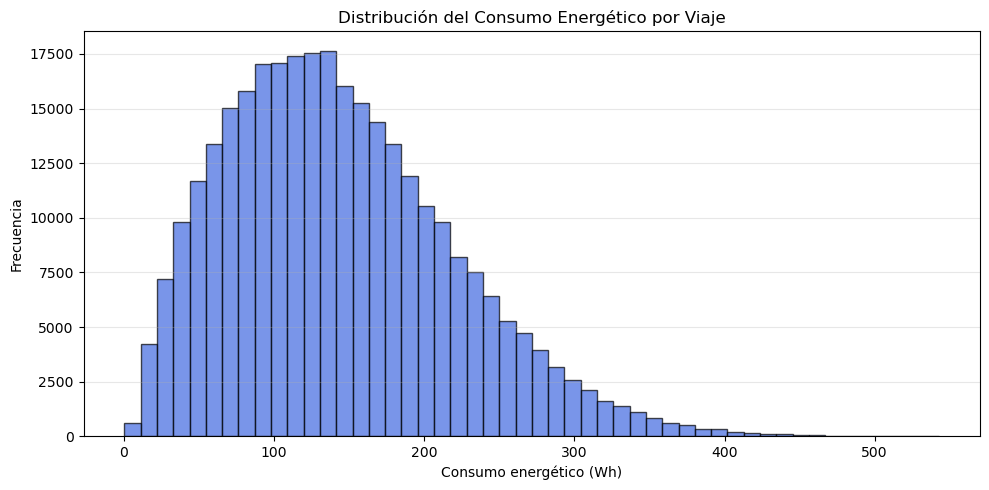

In [184]:
import matplotlib.pyplot as plt

# Suponiendo que ya tienes df_merged con la columna 'Consumo_Wh'
plt.figure(figsize=(10,5))
plt.hist(df_merged['Consumo_Wh'].dropna(), bins=50, color='royalblue', alpha=0.7, edgecolor='k')
plt.title("Distribución del Consumo Energético por Viaje")
plt.xlabel("Consumo energético (Wh)")
plt.ylabel("Frecuencia")
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


In [185]:
import pandas as pd

# Convierte lock_date a datetime si aún no lo está
df_merged['lock_date'] = pd.to_datetime(df_merged['lock_date'])

# Filtra el DataFrame por el día deseado
fecha_objetivo = '2022-06-15'
mask = df_merged['lock_date'].dt.date == pd.to_datetime(fecha_objetivo).date()
df_dia = df_merged[mask].copy()


In [186]:
df_dia['hour'] = df_dia['lock_date'].dt.hour

# Suma el consumo por estación y hora
consumo_hora_estacion = df_dia.groupby(['lock_station_name', 'hour'])['Consumo_Wh'].sum().reset_index()

consumo_hora_estacion.to_csv("consumo_hora_estacion.csv")

In [187]:
consumo_hora_estacion

,lock_station_name,hour,Consumo_Wh
0,10 - Marqués de la Ensenada,1,139.009331
1,10 - Marqués de la Ensenada,19,166.976102
2,100 - Palacio de Deportes,1,172.605071
3,100 - Palacio de Deportes,12,223.078979
4,100 - Palacio de Deportes,16,11.207310
...,...,...,...
856,97 - Alcalá,17,118.572287
857,98 - Plaza de Felipe II,3,127.508932
858,98 - Plaza de Felipe II,14,264.165660
859,99 - Alcántara,10,184.009891


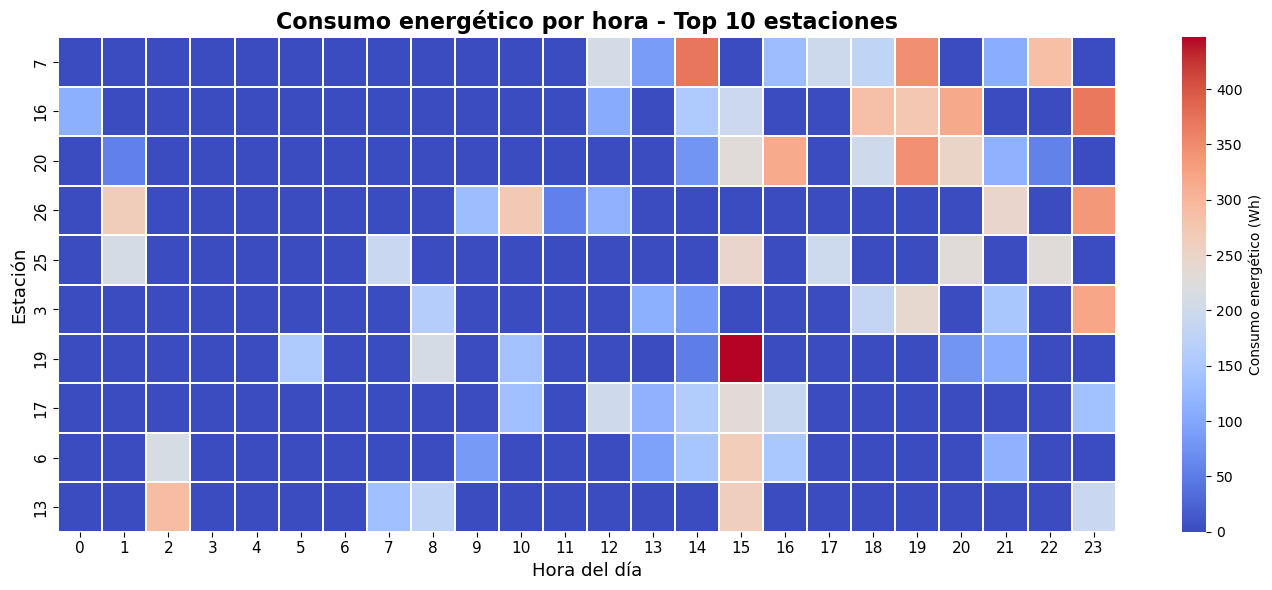

In [188]:
import matplotlib.pyplot as plt
import seaborn as sns

# Supón que tienes tu pivot table como antes: 'pivot'
# Saca las 10 estaciones con mayor consumo total:
top_stations = pivot.sum(axis=1).sort_values(ascending=False).head(10).index
pivot_top = pivot.loc[top_stations]

plt.figure(figsize=(14, 6))
sns.heatmap(
    pivot_top, 
    cmap="coolwarm", 
    linewidths=0.3, 
    cbar_kws={"label": "Consumo energético (Wh)"},
    annot=False  # O True si quieres ver los valores
)

plt.title("Consumo energético por hora - Top 10 estaciones", fontsize=16, fontweight="bold")
plt.xlabel("Hora del día", fontsize=13)
plt.ylabel("Estación", fontsize=13)
plt.yticks(fontsize=11)
plt.xticks(fontsize=11)
plt.tight_layout()
plt.show()


In [127]:
import pandas as pd

# Si no está ya en datetime:
df_merged['lock_date'] = pd.to_datetime(df_merged['lock_date'])

# Filtrar febrero de un año concreto, por ejemplo 2022
df_feb = df_merged[df_merged['lock_date'].dt.month == 2].copy()


In [128]:
df_feb['day'] = df_feb['lock_date'].dt.day
df_feb['Hora'] = df_feb['lock_date'].dt.hour


In [129]:
consumo_cubo = df_feb.groupby(['lock_station_name', 'day', 'hour'])['Consumo_Wh'].sum().reset_index()


In [130]:
estacion = "224 - Caramuel"
cubo_estacion = consumo_cubo[consumo_cubo['lock_station_name'] == estacion]

pivot = cubo_estacion.pivot_table(
    index='day',    # filas = día del mes
    columns='hour', # columnas = hora del día
    values='Consumo_Wh',
    fill_value=0
)
print(pivot)


hour          0           1           2          3           4           5   \
day                                                                           
1       0.000000    0.000000    0.000000    0.00000    0.000000    0.000000   
2       0.000000    0.000000    0.000000    0.00000    0.000000    0.000000   
3       0.000000    0.000000    0.000000    0.00000    0.000000    0.000000   
4       0.000000    0.000000    0.000000    0.00000    0.000000    0.000000   
5       0.000000    0.000000    0.000000  179.60503    0.000000    0.000000   
6       0.000000    0.000000  212.003318    0.00000    0.000000    0.000000   
7       0.000000    0.000000    0.000000    0.00000    0.000000    0.000000   
8       0.000000    0.000000    0.000000    0.00000    0.000000    0.000000   
9       0.000000    0.000000    0.000000    0.00000    0.000000    0.000000   
10      0.000000    0.000000    0.000000    0.00000    0.000000    0.000000   
11      0.000000    0.000000    0.000000    0.00000 

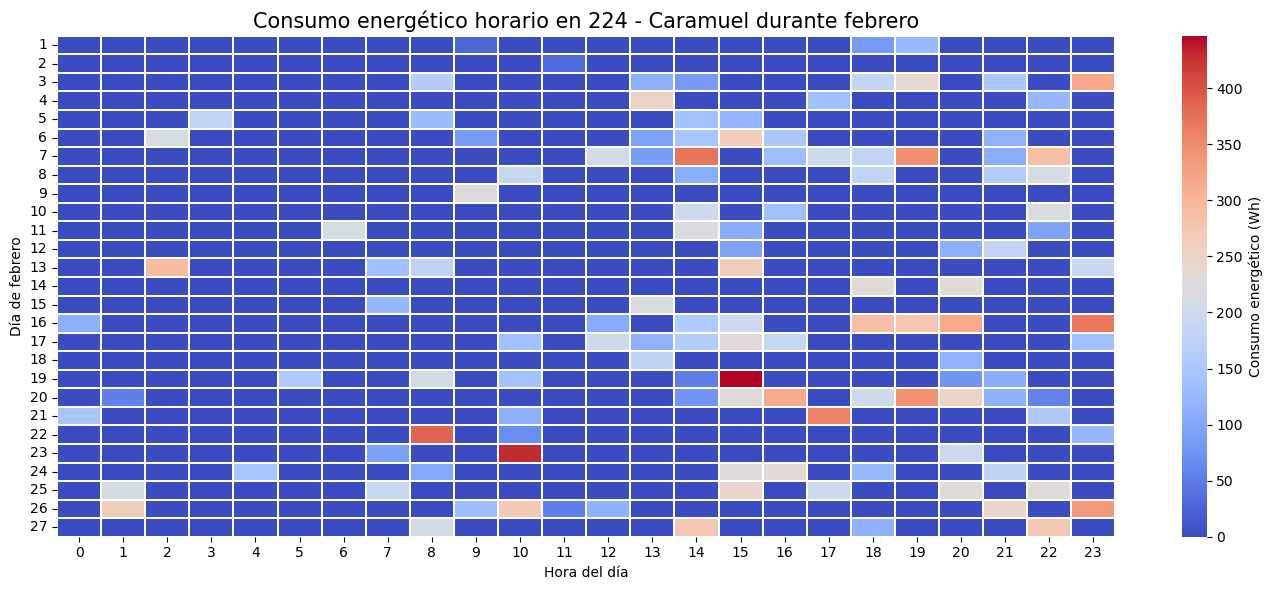

In [131]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14, 6))
sns.heatmap(
    pivot, 
    cmap="coolwarm", 
    linewidths=0.2, 
    cbar_kws={"label": "Consumo energético (Wh)"},
    annot=False
)
plt.title(f"Consumo energético horario en {estacion} durante febrero", fontsize=15)
plt.xlabel("Hora del día")
plt.ylabel("Día de febrero")
plt.tight_layout()
plt.show()


El siguiente mapa de calor representa el consumo energético horario en las 10 estaciones con mayor demanda. Se observa que los picos de consumo se producen habitualmente entre las 9 y las 21.00 horas, siendo la estación Caramuel la que concentra la mayor demanda puntual. Estos datos permiten dimensionar la potencia y la capacidad de recarga necesarias en cada estación, optimizando tanto la inversión como la operación del sistema.

In [132]:
import pandas as pd

# Suponiendo que tu DataFrame general se llama df_merged
df_merged['lock_date'] = pd.to_datetime(df_merged['lock_date'])
df_merged['hour'] = df_merged['lock_date'].dt.hour


In [133]:
consumo_hora_estacion = (
    df_merged.groupby(['lock_station_name', 'hour'])['Consumo_Wh']
    .sum()
    .reset_index()
)


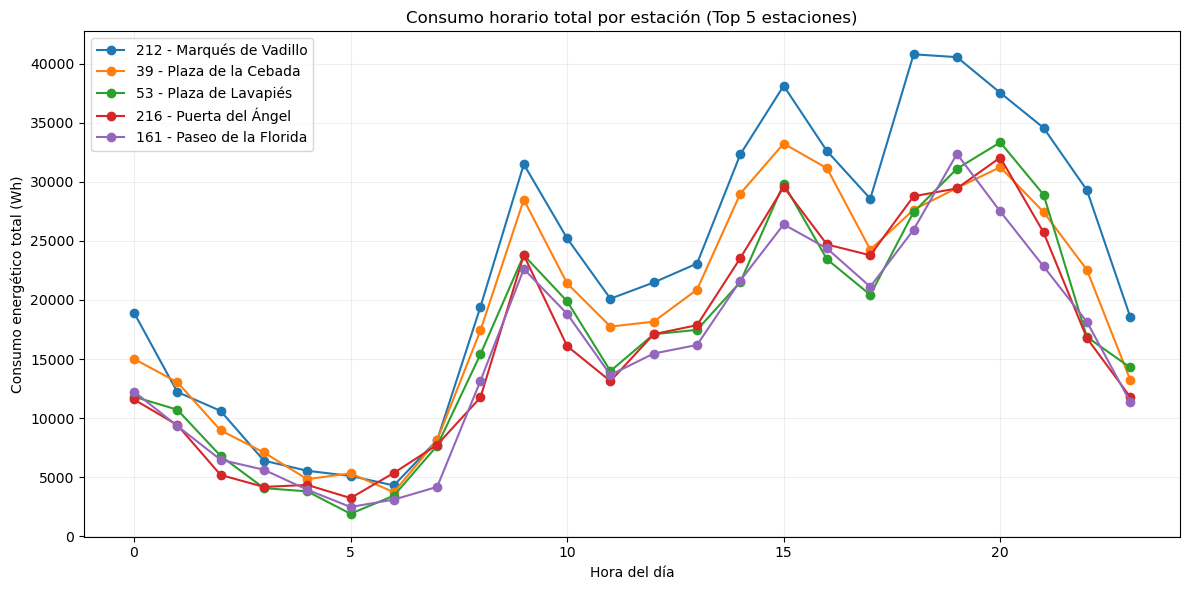

In [134]:
top_stations = (
    df_merged.groupby('lock_station_name')['Consumo_Wh']
    .sum()
    .sort_values(ascending=False)
    .head(5)
    .index
)

plt.figure(figsize=(12,6))
for station in top_stations:
    est = consumo_hora_estacion[consumo_hora_estacion['lock_station_name'] == station]
    plt.plot(est['hour'], est['Consumo_Wh'], marker='o', label=station)

plt.xlabel("Hora del día")
plt.ylabel("Consumo energético total (Wh)")
plt.title("Consumo horario total por estación (Top 5 estaciones)")
plt.legend()
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()


In [135]:
df_merged['date'] = df_merged['lock_date'].dt.date
# Esto te da el consumo total diario por estación
consumo_diario = (
    df_merged.groupby(['lock_station_name', 'date'])['Consumo_Wh']
    .sum()
    .reset_index()
)


In [136]:
# Esto es el consumo medio diario por estación
consumo_medio_diario = (
    consumo_diario.groupby('lock_station_name')['Consumo_Wh']
    .mean()
    .reset_index()
    .rename(columns={'Consumo_Wh': 'Consumo_medio_diario_Wh'})
)

# Puedes ordenar para ver las estaciones más activas:
consumo_medio_diario = consumo_medio_diario.sort_values('Consumo_medio_diario_Wh', ascending=False)
print(consumo_medio_diario.head())




             lock_station_name  Consumo_medio_diario_Wh
126   212 - Marqués de Vadillo              1636.735107
195    39 - Plaza de la Cebada              1379.834000
211     53 - Plaza de Lavapiés              1216.260959
130     216 - Puerta del Ángel              1195.470088
69   161 - Paseo de la Florida              1138.005498


In [137]:
consumo_diario_total = (
    df_merged.groupby('date')['Consumo_Wh'].sum().mean()
)
print(f"Consumo medio diario de toda la red: {consumo_diario_total:.2f} Wh")


Consumo medio diario de toda la red: 132257.04 Wh


# Calculo de la producción por hora en cada estación

### Numero de slots por estación

In [138]:
import pandas as pd
from collections import defaultdict

# 1. Cargar el dataset
df = pd.read_csv("motos.csv")

# 2. Parsear fechas (asegúrate de que estén en formato datetime)
df["unlock_date"] = pd.to_datetime(df["unlock_date"], errors="coerce")
df["lock_date"] = pd.to_datetime(df["lock_date"], errors="coerce")

# 3. Ignorar filas con datos nulos en fechas o estación
df = df.dropna(subset=["unlock_date", "lock_date", "unlock_station_name", "lock_station_name"])

# 4. Crear eventos de llegada y salida
ev_dest = df[["lock_date", "lock_station_name"]].rename(
    columns={"lock_date": "ts", "lock_station_name": "hub"}
).assign(tipo="llegada")
ev_orig = df[["unlock_date", "unlock_station_name"]].rename(
    columns={"unlock_date": "ts", "unlock_station_name": "hub"}
).assign(tipo="salida")

# 5. Unir, limpiar y ordenar eventos
eventos = pd.concat([ev_dest, ev_orig], ignore_index=True)
eventos = eventos.dropna(subset=["ts", "hub"]).sort_values("ts").reset_index(drop=True)
eventos["hub"] = eventos["hub"].astype(str)
eventos["dia"] = eventos["ts"].dt.date
eventos["sem"] = eventos["ts"].dt.isocalendar().week

# 6. Parámetros de simulación
RESET_MODE = "daily"   # Cambia a "weekly" si lo necesitas
SLOT_CAP = 100

slots_tot = defaultdict(lambda: 1)  # Empieza cada estación con 1 slot
slots_occ = defaultdict(int)
slots_pico = defaultdict(int)

# 7. Simulación
for i, ev in eventos.iterrows():
    h = ev["hub"]
    if ev["tipo"] == "llegada":
        if slots_occ[h] < slots_tot[h]:
            slots_occ[h] += 1
        else:
            slots_tot[h] = min(slots_tot[h] + 1, SLOT_CAP)
            slots_occ[h] += 1
        slots_pico[h] = max(slots_pico[h], slots_occ[h])
    else:  # salida
        if slots_occ[h] > 0:
            slots_occ[h] -= 1

    # Reseteo diario o semanal
    nxt = eventos.iloc[i+1] if i < len(eventos) - 1 else None
    reset_cond = (
        (RESET_MODE == "daily" and (nxt is None or nxt["dia"] != ev["dia"])) or
        (RESET_MODE == "weekly" and (nxt is None or nxt["sem"] != ev["sem"]))
    )
    if reset_cond:
        slots_occ = defaultdict(int)

# 8. Resultados
out = (pd.Series(slots_pico, name="slots_optimos")
         .sort_values(ascending=False)
         .reset_index()
         .rename(columns={"index": "hub"}))

print(out.head(10))
print(f"Total de enchufes a instalar: {out['slots_optimos'].sum()}")
out.to_csv("slots_optimos_por_hub_motos_daily.csv", index=False)


                           hub  slots_optimos
0                200 - Quevedo             16
1    161 - Paseo de la Florida             15
2     212 - Marqués de Vadillo             14
3   127 - Fernando el Católico             14
4       53 - Plaza de Lavapiés             14
5            16 - San Bernardo             14
6      39 - Plaza de la Cebada             13
7       216 - Puerta del Ángel             13
8    171 - Embajadores-Cáceres             13
9  233 - Marqués de Corbera 12             13
Total de enchufes a instalar: 2161


In [139]:
import pandas as pd
from collections import defaultdict

# 1. Cargar el dataset
df = pd.read_csv("motos.csv")

# 2. Parsear fechas (asegúrate de que estén en formato datetime)
df["unlock_date"] = pd.to_datetime(df["unlock_date"], errors="coerce")
df["lock_date"] = pd.to_datetime(df["lock_date"], errors="coerce")

# 3. Ignorar filas con datos nulos en fechas o estación
df = df.dropna(subset=["unlock_date", "lock_date", "unlock_station_name", "lock_station_name"])

# 4. Crear eventos de llegada y salida
ev_dest = df[["lock_date", "lock_station_name"]].rename(
    columns={"lock_date": "ts", "lock_station_name": "hub"}
).assign(tipo="llegada")
ev_orig = df[["unlock_date", "unlock_station_name"]].rename(
    columns={"unlock_date": "ts", "unlock_station_name": "hub"}
).assign(tipo="salida")

# 5. Unir, limpiar y ordenar eventos
eventos = pd.concat([ev_dest, ev_orig], ignore_index=True)
eventos = eventos.dropna(subset=["ts", "hub"]).sort_values("ts").reset_index(drop=True)
eventos["hub"] = eventos["hub"].astype(str)
eventos["dia"] = eventos["ts"].dt.date
eventos["sem"] = eventos["ts"].dt.isocalendar().week

# 6. Parámetros de simulación
RESET_MODE = "weekly"   # Cambia a "weekly" si lo necesitas
SLOT_CAP = 100

slots_tot = defaultdict(lambda: 1)  # Empieza cada estación con 1 slot
slots_occ = defaultdict(int)
slots_pico = defaultdict(int)

# 7. Simulación
for i, ev in eventos.iterrows():
    h = ev["hub"]
    if ev["tipo"] == "llegada":
        if slots_occ[h] < slots_tot[h]:
            slots_occ[h] += 1
        else:
            slots_tot[h] = min(slots_tot[h] + 1, SLOT_CAP)
            slots_occ[h] += 1
        slots_pico[h] = max(slots_pico[h], slots_occ[h])
    else:  # salida
        if slots_occ[h] > 0:
            slots_occ[h] -= 1

    # Reseteo diario o semanal
    nxt = eventos.iloc[i+1] if i < len(eventos) - 1 else None
    reset_cond = (
        (RESET_MODE == "daily" and (nxt is None or nxt["dia"] != ev["dia"])) or
        (RESET_MODE == "weekly" and (nxt is None or nxt["sem"] != ev["sem"]))
    )
    if reset_cond:
        slots_occ = defaultdict(int)

# 8. Resultados
out = (pd.Series(slots_pico, name="slots_optimos")
         .sort_values(ascending=False)
         .reset_index()
         .rename(columns={"index": "hub"}))

print(out.head(10))
print(f"Total de enchufes a instalar: {out['slots_optimos'].sum()}")
out.to_csv("slots_optimos_por_hub_motos_weekly.csv", index=False)


KeyboardInterrupt: 

## Calculo de la producción por horas

Los siguientes datos serán obtenidos por [https://selectra.es/autoconsumo/info/tarifas#precio-excedentes-autoconsumo]

df_slots = pd.read_csv("slots_optimos_por_hub_motos_daily.csv")
df_pv = pd.read_csv("pvwatts_hourly_limpio.csv")

In [97]:
import pandas as pd

df_pv = pd.read_csv("pvwatts_hourly_limpio.csv")

# Crea columna datetime con año (asume 2022 como pusiste antes)
df_pv['date'] = pd.to_datetime(df_pv[['Month', 'Day']].astype(str).agg('-'.join, axis=1) + '-2022')

# Calcula la media horaria de 1 sistema para cada hora (0-23)
# Agrupa por la columna "Hour" (de 0 a 23)
prod_hora_media = df_pv.groupby('Hour')['AC System Output (W)'].mean().reset_index()
prod_hora_media.rename(columns={'AC System Output (W)': 'prod_hora_media_panel_Wh'}, inplace=True)

print(prod_hora_media)


    Hour  prod_hora_media_panel_Wh
0      0                  0.000000
1      1                  0.000000
2      2                  0.000000
3      3                  0.000000
4      4                  0.000000
5      5                  0.000000
6      6                  0.364241
7      7                  5.696052
8      8                 23.903616
9      9                 49.148014
10    10                 78.071775
11    11                 98.451082
12    12                109.390178
13    13                111.492989
14    14                108.419044
15    15                 94.938562
16    16                 73.184877
17    17                 43.161132
18    18                 17.164118
19    19                  3.265781
20    20                  0.371534
21    21                  0.000000
22    22                  0.000000
23    23                  0.000000


In [105]:
df_slots = pd.read_csv("slots_optimos_por_hub_motos_daily.csv")
df_slots['n_paneles'] = (df_slots['slots_optimos'] * 1).round().astype(int)

# Producto cruzado: todas las estaciones x todas las horas
df_slots['key'] = 1
prod_hora_media['key'] = 1
df_est_hora = df_slots.merge(prod_hora_media, on='key').drop('key', axis=1)

# Calcula la producción horaria para cada estación
df_est_hora['prod_solar_hub_hora_Wh'] = df_est_hora['n_paneles'] * df_est_hora['prod_hora_media_panel_Wh']


# Opcional: selecciona solo columnas importantes
df_result = df_est_hora[['hub', 'Hour', 'n_paneles', 'prod_solar_hub_hora_Wh']]
df_result.to_csv("produccion_solar_horaria_por_estacion.csv", index=False)
print(df_result.head(24))


              hub  Hour  n_paneles  prod_solar_hub_hora_Wh
0   200 - Quevedo     0         16                0.000000
1   200 - Quevedo     1         16                0.000000
2   200 - Quevedo     2         16                0.000000
3   200 - Quevedo     3         16                0.000000
4   200 - Quevedo     4         16                0.000000
5   200 - Quevedo     5         16                0.000000
6   200 - Quevedo     6         16                5.827858
7   200 - Quevedo     7         16               91.136833
8   200 - Quevedo     8         16              382.457863
9   200 - Quevedo     9         16              786.368219
10  200 - Quevedo    10         16             1249.148405
11  200 - Quevedo    11         16             1575.217315
12  200 - Quevedo    12         16             1750.242849
13  200 - Quevedo    13         16             1783.887825
14  200 - Quevedo    14         16             1734.704701
15  200 - Quevedo    15         16             1519.0169

In [106]:
import pandas as pd

# Consumo horario medio por estación
df_consumo = pd.read_csv("consumo_hora_estacion.csv")  # columnas: hub, Hora, Consumo_Wh

# Si tu columna de hora se llama distinto, renómbrala para que coincida
df_consumo.rename(columns={'Hora': 'Hour'}, inplace=True)


In [107]:
import unicodedata

def normalizar(texto):
    if pd.isnull(texto):
        return ""
    texto = str(texto).lower()
    texto = ''.join(
        c for c in unicodedata.normalize('NFD', texto)
        if unicodedata.category(c) != 'Mn'
    )
    texto = texto.strip()
    return texto

df_consumo['hub_norm'] = df_consumo['hub'].apply(normalizar)
df_prod_h = pd.read_csv("produccion_solar_horaria_por_estacion.csv")
df_prod_h['hub_norm'] = df_prod_h['hub'].apply(normalizar)


In [108]:
# Merge por hub normalizado y hora
df_comparacion = df_consumo.merge(
    df_prod_h[['hub_norm', 'Hour', 'prod_solar_hub_hora_Wh']],
    on=['hub_norm', 'Hour'],
    how='outer'
)

# Calcula el balance horario solar - consumo
df_comparacion['balance_Wh'] = df_comparacion['prod_solar_hub_hora_Wh'] - df_comparacion['Consumo_Wh']

# Opcional: filtra columnas para claridad
df_comparacion = df_comparacion[['hub', 'Hour', 'Consumo_Wh', 'prod_solar_hub_hora_Wh', 'balance_Wh']]
df_comparacion.to_csv("comparacion_solar_vs_consumo_horario.csv", index=False)
print(df_comparacion.head(24))


                            hub  Hour  Consumo_Wh  prod_solar_hub_hora_Wh  \
0   10 - marqués de la ensenada     0   79.240275                0.000000   
1   10 - marqués de la ensenada     1  121.254279                0.000000   
2   10 - marqués de la ensenada     2   75.778189                0.000000   
3   10 - marqués de la ensenada     3  107.377006                0.000000   
4   10 - marqués de la ensenada     4  116.297325                0.000000   
5   10 - marqués de la ensenada     5   98.508138                0.000000   
6   10 - marqués de la ensenada     6   97.420993                1.821205   
7   10 - marqués de la ensenada     7  100.927126               28.480260   
8   10 - marqués de la ensenada     8  111.146873              119.518082   
9   10 - marqués de la ensenada     9  117.577315              245.740068   
10  10 - marqués de la ensenada    10  107.019936              390.358877   
11  10 - marqués de la ensenada    11  101.100259              492.255411   

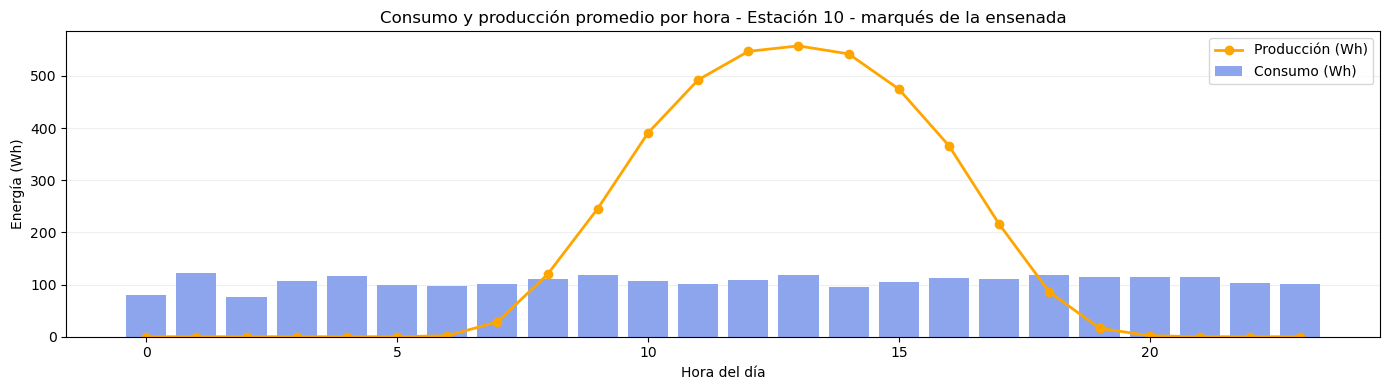

In [111]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,4))  # Gráfico apaisado, igual que el tuyo

plt.bar(df_plot['Hour'], df_plot['Consumo_Wh'], color='royalblue', alpha=0.6, label='Consumo (Wh)')
plt.plot(df_plot['Hour'], df_plot['prod_solar_hub_hora_Wh'], color='orange', marker='o', label='Producción (Wh)', linewidth=2)

plt.xlabel('Hora del día')
plt.ylabel('Energía (Wh)')
plt.title('Consumo y producción promedio por hora - Estación ' + str(df_plot['hub'].iloc[0]))
plt.legend()
plt.grid(axis='y', alpha=0.2)
plt.tight_layout()
plt.show()


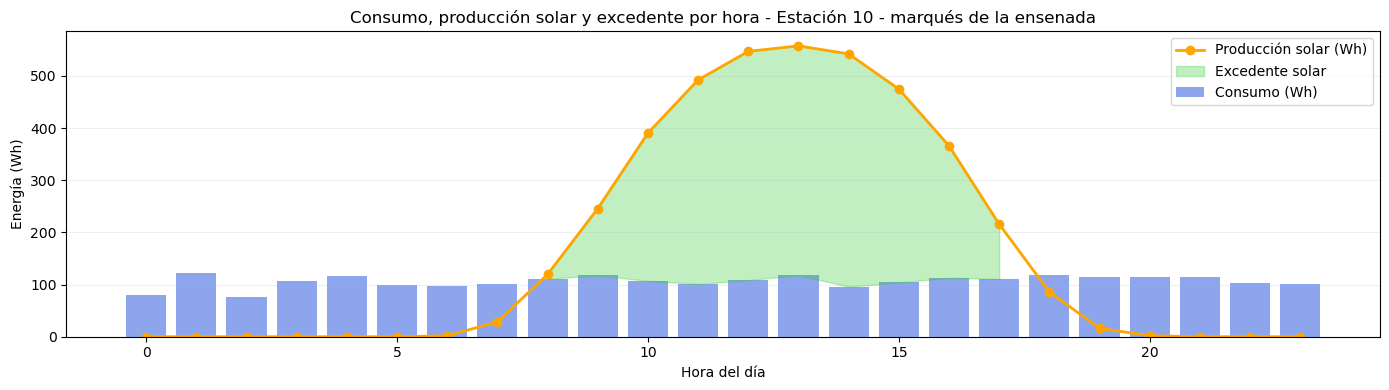

In [112]:
import matplotlib.pyplot as plt
import numpy as np

# Supón que tienes df_plot con columnas: Hour, Consumo_Wh, prod_solar_hub_hora_Wh, hub

plt.figure(figsize=(14,4))

# Barras azules para el consumo
plt.bar(df_plot['Hour'], df_plot['Consumo_Wh'], color='royalblue', alpha=0.6, label='Consumo (Wh)')

# Línea naranja para la producción solar
plt.plot(df_plot['Hour'], df_plot['prod_solar_hub_hora_Wh'], color='orange', marker='o', label='Producción solar (Wh)', linewidth=2)

# Calcular el excedente (solo donde la producción supera el consumo)
excedente = np.maximum(df_plot['prod_solar_hub_hora_Wh'] - df_plot['Consumo_Wh'], 0)

# Sombrear el excedente
plt.fill_between(df_plot['Hour'], df_plot['Consumo_Wh'], df_plot['Consumo_Wh'] + excedente,
                 where=excedente > 0, color='limegreen', alpha=0.3, label='Excedente solar')

plt.xlabel('Hora del día')
plt.ylabel('Energía (Wh)')
plt.title('Consumo, producción solar y excedente por hora - Estación ' + str(df_plot['hub'].iloc[0]))
plt.legend()
plt.grid(axis='y', alpha=0.2)
plt.tight_layout()
plt.show()


# Análisis financiero

In [116]:
import pandas as pd

# Cargar el archivo CSV que contiene el número de paneles por estación
df_slots = pd.read_csv("slots_optimos_por_hub_motos_daily.csv")

# Calcular el número de paneles (asumiendo 1 paneles por slot óptimo)
df_slots['n_paneles'] = (df_slots['slots_optimos'] * 1).round().astype(int)

# Calcular la superficie total por estación (asumiendo 1m² por panel)
df_slots['superficie_m2'] = df_slots['n_paneles'] * 1

# Calcular la superficie total de todas las estaciones
superficie_total = df_slots['superficie_m2'].sum()

print(f"Superficie total de paneles solares: {superficie_total:.2f} m²")

# Guardar los resultados en un nuevo archivo CSV
df_slots.to_csv("superficie_paneles_por_estacion.csv", index=False)


Superficie total de paneles solares: 2161.00 m²


Suponiendo un precio de 700€ el m2, el coste de instalación y materiales para cubrir 2161.00 m2

In [117]:
df_slots["slots_optimos"].sum()

np.int64(2161)

In [147]:
# Cargar datos de slots y producción
df_slots = pd.read_csv("slots_optimos_por_hub_motos_daily.csv")
n_total_paneles = df_slots['slots_optimos'].sum()

df_pv = pd.read_csv("pvwatts_hourly_limpio.csv")
df_pv['Year'] = 2022
df_pv['Month'] = df_pv['Month'].astype(int)
df_pv['AC System Output (W)'] = pd.to_numeric(df_pv['AC System Output (W)'], errors='coerce').fillna(0)

# Producción mensual de UN panel
prod_mes_panel = df_pv.groupby('Month')['AC System Output (W)'].sum().reset_index()

# Producción total mensual de la red (todos los paneles)
prod_mes_panel['prod_mes_total_Wh'] = prod_mes_panel['AC System Output (W)'] * n_total_paneles
prod_mes_panel['prod_mes_total_kWh'] = prod_mes_panel['prod_mes_total_Wh'] / 1000

# Producción media mensual (media aritmética)
produccion_medio_mes_kWh = prod_mes_panel['prod_mes_total_kWh'].mean()
print(f"Producción solar media mensual de toda la red: {produccion_medio_mes_kWh:.2f} kWh")


Producción solar media mensual de toda la red: 53703.26 kWh


In [148]:
import pandas as pd

# Cargar el dataframe de viajes
df_viajes = pd.read_csv("viajes_motos_con_consumo.csv")
df_viajes['lock_date'] = pd.to_datetime(df_viajes['lock_date'])
df_viajes['Month'] = df_viajes['lock_date'].dt.month
df_viajes['Year'] = df_viajes['lock_date'].dt.year

# Consumo total mensual de toda la red
consumo_mes = df_viajes.groupby(['Year', 'Month'])['Consumo_Wh'].sum().reset_index()
consumo_mes['Consumo_kWh'] = consumo_mes['Consumo_Wh'] / 1000

# Consumo medio mensual (media aritmética)
consumo_medio_mes_kWh = consumo_mes['Consumo_kWh'].mean()
print(f"Consumo medio mensual de toda la red: {consumo_medio_mes_kWh:.2f} kWh")


Consumo medio mensual de toda la red: 4015.80 kWh


In [153]:
# Agregar columna de ingresos por viaje usando distribución 60% básica y 40% seguro plus

df = pd.read_csv("motos.csv")

tarifa_basica = 0.26
tarifa_plus = 0.28

# Supón que no hay columna que distinga tarifa, asignamos al azar pero con 60-40
import numpy as np

np.random.seed(42)
n = len(df)
# 60% básica, 40% plus
tipos = np.random.choice(['basica', 'plus'], size=n, p=[0.6, 0.4])
df['tarifa_tipo'] = tipos
df['precio_minuto'] = np.where(df['tarifa_tipo'] == 'basica', tarifa_basica, tarifa_plus)
df['ingreso_viaje'] = df['trip_minutes'] * df['precio_minuto']

# Extraer el mes y año de la fecha de inicio
df['unlock_date'] = pd.to_datetime(df['unlock_date'], errors='coerce')
df['mes'] = df['unlock_date'].dt.to_period('M')

# Ganancia total, mensual y anual
ganancia_total = df['ingreso_viaje'].sum()
ganancia_mensual = df.groupby('mes')['ingreso_viaje'].sum()
ganancia_anual = df.groupby(df['unlock_date'].dt.year)['ingreso_viaje'].sum()

ganancia_total, ganancia_mensual.head(), ganancia_anual.head()


(np.float64(1012859.4846162698),
 mes
 2022-04    90695.136959
 2022-05    95288.905151
 2022-06    91837.472555
 2022-07    94917.147739
 2022-08    93540.477877
 Freq: M, Name: ingreso_viaje, dtype: float64,
 unlock_date
 2022    837945.250317
 2023    174914.234299
 Name: ingreso_viaje, dtype: float64)

Podemos observar que la ganancia anual es de 837945.25€